## VDSR Implementation

### Learning Based Method
앞에선 Interpolation based method로 해상도를 키우는 작업을 해보았습니다. 하지만, 딥러닝을 이용한다면 어떨까요?  
2010년대 Deep Learning을 통한 이미지 분류 등이 핫해지면서 SR 분야에서도 딥러닝을 이용하는 논문들이 많이 등장하게 되었습니다.  
그 중 하나인 VDSR를 직접 구현해보려 합니다.

In [1]:
!rm -rf ./VDSR
!git clone https://github.com/FYLSunghwan/VDSR-pytorch.git ./VDSR

'./VDSR'에 복제합니다...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 288 (delta 23), reused 44 (delta 14), pack-reused 226
오브젝트를 받는 중: 100% (288/288), 419.84 MiB | 15.91 MiB/s, 완료.
델타를 알아내는 중: 100% (38/38), 완료.


In [2]:
import sys
sys.path.insert(1, './VDSR')

from settings import Settings
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from utils.datasets import TrainDataset, TestDataset
from torchvision.transforms import *
from torch.autograd import Variable
from PIL import Image
from utils.psnr import PSNR
import numpy as np

먼저 데이터셋을 불러와야겠죠? 논문에서 사용된 데이터셋을 살펴봅시다.  
291이라는 이름의 데이터셋을 사용하였네요. 미리 제가 만들어놓은 데이터셋을 불러오기 위해 다음과 같이 불러오는 함수를 만들어봅시다.

In [3]:
settings = Settings()
def load_dataset(dataset='train'):
    if dataset == 'train':
        print('Loading train datasets...')
        train_set = TrainDataset(settings=settings)
        return DataLoader(dataset=train_set, num_workers=settings.num_threads, batch_size=64,
                          shuffle=True, drop_last=True)
    elif dataset == 'test':
        print('Loading test datasets...')
        test_set = TestDataset(settings=settings)
        return DataLoader(dataset=test_set, num_workers=settings.num_threads, batch_size=1,
                          shuffle=False)
    
train_data = load_dataset('train')
test_data = load_dataset('test')

Loading train datasets...


27563KB [00:00, 47000.04KB/s]


Unzipping...
Successfully downloaded '291' dataset @ [/home/fylsunghwan/github/CV_2020/lab02_Super_Resolution_with_Deep_Learning/VDSR/datasets/291]
Successfully loaded.
/home/fylsunghwan/github/CV_2020/lab02_Super_Resolution_with_Deep_Learning/VDSR/datasets/291
Loading test datasets...


309757KB [00:20, 15283.62KB/s]


Unzipping...
Successfully downloaded 'SR_testing_datasets' dataset @ [/home/fylsunghwan/github/CV_2020/lab02_Super_Resolution_with_Deep_Learning/VDSR/datasets/SR_testing_datasets]
Successfully loaded.


Text(0.5, 1.0, 'High Resolution')

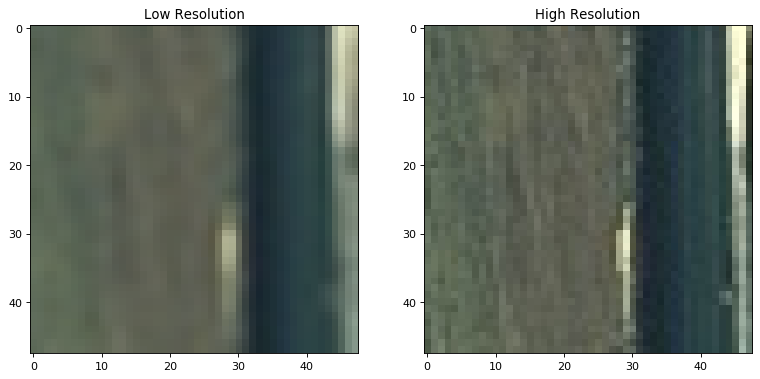

In [4]:
lr = None
hr = None

for idx, batch in enumerate(train_data):
    lr = batch[0][0].numpy().transpose(2,1,0)
    hr = batch[1][0].numpy().transpose(2,1,0)

fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(lr)
ax.set_title("Low Resolution")

ax = plt.subplot("132")
ax.imshow(hr)
ax.set_title("High Resolution")

논문에서 사용한 모델을 차근차근 따라가며 만들어볼게요.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        nn.init.xavier_uniform_(self.input.weight, gain=nn.init.calculate_gain('relu'))
        self.conv_layer = self.make_layer(Conv_Block, 18)
        self.output = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)
        nn.init.xavier_uniform_(self.output.weight, gain=nn.init.calculate_gain('relu'))
        self.relu = nn.ReLU(inplace=True)


    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        res = x
        out = self.relu(self.input(x))
        out = self.conv_layer(out)
        out = self.output(out)
        out = out + res
        return out

    def withoutres(self, x):
        res = x
        out = self.relu(self.input(x))
        out = self.conv_layer(out)
        out = self.output(out)
        out = out
        return out

미리 학습한 모델을 불러오고,
논문에서 사용한 optimizer와 loss를 그대로 써볼까요.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torch.load('VDSR/checkpoint/model_epoch_36.pth')['model'].to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.MSELoss()

Train 코드를 짜볼게요.

In [7]:
def train(training_data_loader, testing_data_loader, optimizer, model, criterion, epoch):
    for param_group in optimizer.param_groups:
        lr = param_group["lr"]
        
    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))
    avg_loss = 0.0
    for i in range(2490):
        if i%100==0:
            print(">> {}/2490".format(i))
        for iteration, batch in enumerate(training_data_loader):
            input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)
            input = input.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            loss = criterion(model(input), target)
            loss.backward() 

            nn.utils.clip_grad_norm_(model.parameters(), settings.clip) 
            optimizer.step()
            
            avg_loss += loss.item()
            log_iter += 1
        
        with torch.no_grad():
            psnrs = []
            bic_psnrs = []
            cnt = 0
            for iteration, batch in enumerate(testing_data_loader):
                bicubic, hires = Variable(batch[0], requires_grad=False), batch[1]
                bicubic = bicubic.to(device)
                out = model(bicubic).cpu().detach().numpy().squeeze(0)
                
                bicubic = bicubic.cpu().detach().numpy().squeeze(0)
                hires = hires.squeeze(0)
                
                bicubic *= 255
                hires *= 255
                out *= 255
                
                bicubic = np.float32(bicubic).transpose(2,1,0)
                hires = np.float32(hires).transpose(2,1,0)
                out = np.float32(out).transpose(2,1,0)

                ps = PSNR(hires, out, ycbcr=True)
                bps = PSNR(hires, bicubic, ycbcr=True)

                psnrs.append(ps)
                bic_psnrs.append(bps)
                
            avg_psnr = np.mean(psnrs)
            avg_bic_psnr = np.mean(bic_psnrs)
            print(avg_psnr)

학습은 너무 오래걸려서 못하지만, 한번 테스트를 굴려봅시다.

In [8]:
test = test_data.dataset.__getitem__(2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


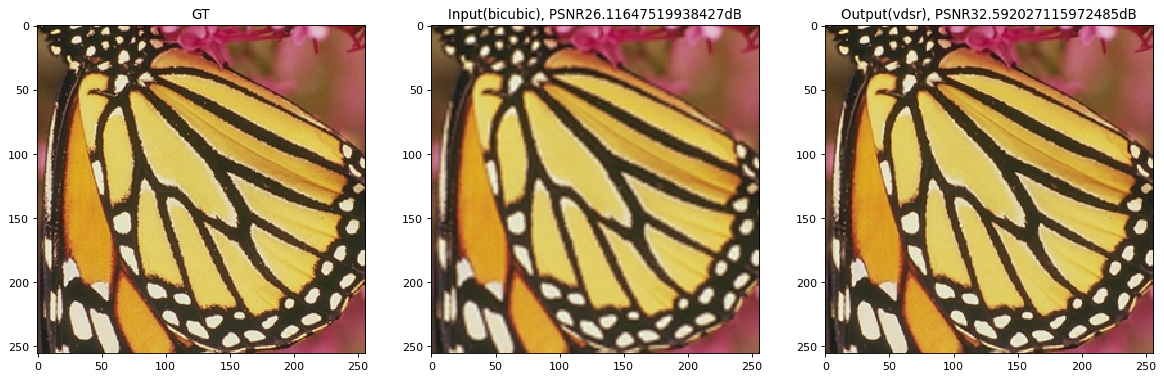

In [9]:
bef = test[1].numpy() *255
aft = model(torch.Tensor(test[0].numpy()).unsqueeze(0).to(device)).cpu().detach().numpy().squeeze(0)*255
bic = test[0].numpy() * 255
psnr = PSNR(bef, aft)
psnr_bic = PSNR(bef, bic)
# Result visualization
fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(test[1].numpy().transpose((2, 1, 0)))
ax.set_title("GT")

ax = plt.subplot("132")
ax.imshow(test[0].numpy().transpose((2, 1, 0)))
ax.set_title("Input(bicubic), PSNR"+str(psnr_bic)+"dB")

ax = plt.subplot("133")
ax.imshow(model(torch.Tensor(test[0].numpy()).unsqueeze(0).to(device)).cpu().detach().numpy().squeeze(0).transpose(2,1,0))
ax.set_title("Output(vdsr), PSNR"+str(psnr)+"dB")
plt.show()

Residual을 거치기 전 이미지도 한번 볼게요.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


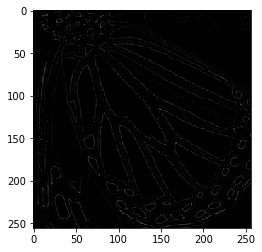

In [10]:
plt.imshow(model.withoutres(torch.Tensor(test[0].numpy()).unsqueeze(0).to(device)).cpu().detach().numpy().squeeze(0).transpose(2,1,0))

보이시나요? 모델의 인풋과 아웃풋의 차이를 나타낸 Residual의 모습입니다.  
이미지의 화질을 향상시키기 위해서는 저 테두리 부분을 더 선명하게 해야할 것입니다.  
실제로, 학습한 Residual의 모습을 보면 저 테두리만 보이는 것을 알 수 있습니다.  
이 의미는 VDSR 모델이 저 테두리 부분 위주로 SR을 진행한다는 것을 알 수 있습니다.  

PSNR이라는 것을 한번 계산해볼게요.  
PSNR이란, Peak Signal to Noise Ratio라는 뜻으로, 한국어로는 최대 신호 대 잡음비라고 합니다.  
보통 이미지 분석이나 영상 압축 등에서 성능의 지표로 많이 사용되는 수치입니다.  
위키백과에선 이렇게 말하네요.  
>최대 신호 대 잡음비(Peak Signal-to-noise ratio, PSNR)는 신호가 가질 수 있는 최대 전력에 대한 잡음의 전력을 나타낸 것이다. 주로 영상 또는 동영상 손실 압축에서 화질 손실 정보를 평가할때 사용된다.  

식은 다음과 같습니다.  

$ \mbox{PSNR} = 10\log_{10} \frac{max^{2}}{MSE}$  

그럼 제가 사전에 작성한 코드로 PSNR을 계산해볼게요.

In [11]:
dbs = []
for _, batch in enumerate(test_data):
    bicubic, hires = Variable(batch[0], requires_grad=False), batch[1]
    bicubic = bicubic.to(device)
    out = model(bicubic).cpu().detach().numpy().squeeze(0)

    bicubic = bicubic.cpu().detach().numpy().squeeze(0)
    hires = hires.squeeze(0)

    hires *= 255
    out *= 255

    bicubic = np.uint8(bicubic).transpose(2,1,0)
    hires = np.float32(hires).transpose(2,1,0)
    out = np.float32(out).transpose(2,1,0)

    ps = PSNR(hires, out, ycbcr=True)
    dbs.append(ps)

print("Average PSNR of dataset",settings.dataset_info['SR_testing_datasets']['id'],"is",np.mean(dbs))

Average PSNR of dataset Set5 is 37.1976614694172


그럼 한번 여러분의 이미지를 직접 모델에 집어넣어보죠.

Enviroment is not Google Colab.
Trying to load test.jpg
cuda
300 300


Text(0.5, 1.0, 'After VDSR')

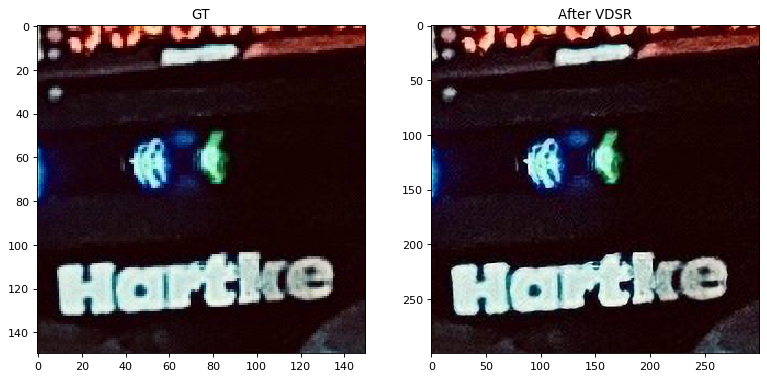

In [12]:
from demo import main
!mkdir checkpoint
!cp VDSR/checkpoint/model_epoch_36.pth checkpoint/model_epoch_36.pth

try:
    uploaded = files.upload()

    files = uploaded.keys()
    filename = None
    for name in files:
      filename = name
      break
    !mv {filename} test.jpg
except:
    print('Enviroment is not Google Colab.\nTrying to load test.jpg')
main()
before = Image.open('test.jpg')
after = Image.open('out.jpg')

fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(before)
ax.set_title("GT")

ax = plt.subplot("132")
ax.imshow(after)
ax.set_title("After VDSR")

이것으로 VDSR 구현을 마쳤습니다!